Found 2041 files belonging to 2 classes.
Using 1633 files for training.
Found 2041 files belonging to 2 classes.
Using 408 files for validation.


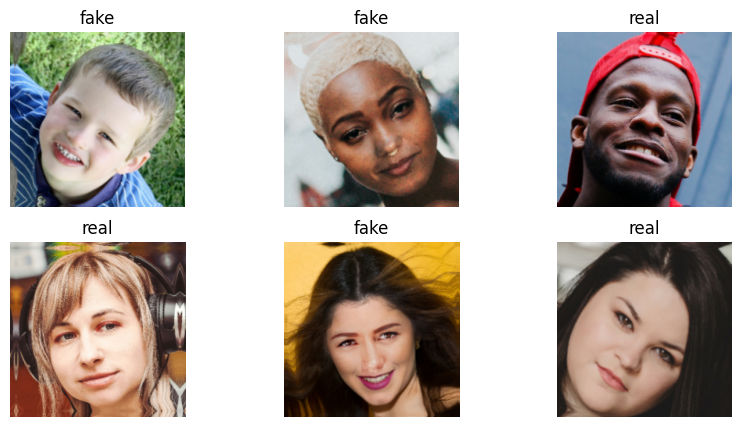

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 733ms/step - accuracy: 0.5268 - loss: 0.7706 - val_accuracy: 0.5417 - val_loss: 0.6919
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 757ms/step - accuracy: 0.5799 - loss: 0.7167 - val_accuracy: 0.5980 - val_loss: 0.6507
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 43s 830ms/step - accuracy: 0.5957 - loss: 0.6910 - val_accuracy: 0.5980 - val_loss: 0.6384
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 763ms/step - accuracy: 0.6250 - loss: 0.6728 - val_accuracy: 0.6029 - val_loss: 0.6386
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 39s 747ms/step - accuracy: 0.6096 - loss: 0.6586 - val_accuracy: 0.6373 - val_loss: 0.6432
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 731ms/step - accuracy: 0.6268 - loss: 0.6534 - val_accuracy: 0.5956 - val_loss: 0.6420
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 751ms/step - accuracy: 0.6229 - loss: 0.6560 - val_accuracy: 0.6250 - val_loss: 0.6340
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 808ms/step - accuracy: 0.6155 - loss: 0.6495 - val_accu

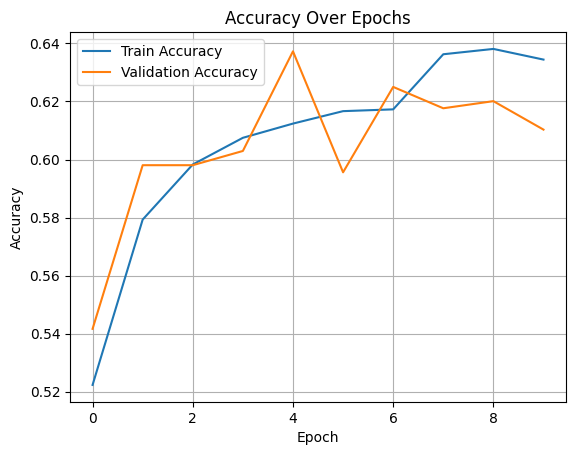

✅ Model saved to model/fake_image_model.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 439ms/step - accuracy: 0.6280 - loss: 0.6329

🎯 Final Validation Accuracy: 61.03%


In [1]:
# 👨‍💻 STEP 1: Imports and Paths
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Paths
DATASET_PATH = "dataset"  # contains 'real/' and 'fake/'
MODEL_PATH = "model/fake_image_model.h5"

# Image settings
img_size = (224, 224)
batch_size = 32

# 👨‍💻 STEP 2: Load Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names

# 👨‍💻 STEP 3: Data Augmentation (Optional but Good)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

# 👨‍💻 STEP 4: Normalization + Performance Boost
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# 👨‍💻 STEP 5: Visualize Sample Images
plt.figure(figsize=(10, 5))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

# 👨‍💻 STEP 6: Load MobileNetV2 (Frozen)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # ❄️ Freeze it

# 👨‍💻 STEP 7: Add Custom Head
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

# 👨‍💻 STEP 8: Compile Model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 👨‍💻 STEP 9: Train the Model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

# 👨‍💻 STEP 10: Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# 👨‍💻 STEP 11: Save Model
os.makedirs("model", exist_ok=True)
model.save(MODEL_PATH)
print(f"✅ Model saved to {MODEL_PATH}")

# 👨‍💻 STEP 12: Final Accuracy
loss, acc = model.evaluate(val_ds)
print(f"\n🎯 Final Validation Accuracy: {acc * 100:.2f}%")
